## Python notebook 
V nasledujúcom notebooku sú popísané Python metódy použité pre zhlukovanie metódou k-Means. Obsah notebooku je nasledujúci:
1. Import potrebných knižníc
2. Vytvorenie autoenkódera
3. Načítanie a predspracovanie dát
4. Zhlukovanie

# 1. Import potrebných knižníc

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D, Dropout, Activation
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import sklearn.metrics
import random

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from tensorflow import keras
import time

# 2. Vytvorenie autoenkódera
Načítame dáta na trénovanie a validáciu enkódera a následne enkóder trénujeme na 40 epoch.

In [2]:
#načítanie trénovacích a validačných dát enkódera
X_train = pickle.load(open('data/X_train.pkl', 'rb'))
y_train = pickle.load(open('data/y_train.pkl', 'rb'))

X_valid = pickle.load(open('data/X_valid.pkl', 'rb'))
y_valid = pickle.load(open('data/y_valid.pkl', 'rb'))

In [4]:
#normalizácia dát
X_train = np.asarray(X_train, dtype=np.float32)/255
X_valid = np.asarray(X_valid, dtype=np.float32)/255

In [5]:
#overenie tvaru dát
print(X_train.shape)
print(X_valid.shape)

(2322, 150, 40, 3)
(175, 150, 40, 3)


In [6]:
#encoder
input_img = keras.Input(shape=(150, 40, 3))

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((3, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# veľkosť reprezentácie dát je (25, 10, 64)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((3, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 40, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 40, 128)      3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 20, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 20, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 10, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 50, 20, 64)       

In [8]:
saved_model = "encoder.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [9]:
history = autoencoder.fit(X_train, X_train, epochs = 40, validation_data=(X_valid, X_valid), batch_size = 32, callbacks = callbacks_list)

Epoch 1/40
73/73 [==============================] - ETA: 0s - loss: 0.4762
Epoch 00001: val_loss improved from inf to 0.43682, saving model to encoder.hdf5
73/73 [==============================] - 6s 80ms/step - loss: 0.4762 - val_loss: 0.4368
Epoch 2/40
72/73 [============================>.] - ETA: 0s - loss: 0.4340
Epoch 00002: val_loss improved from 0.43682 to 0.42976, saving model to encoder.hdf5
73/73 [==============================] - 5s 66ms/step - loss: 0.4340 - val_loss: 0.4298
Epoch 3/40
72/73 [============================>.] - ETA: 0s - loss: 0.4294
Epoch 00003: val_loss improved from 0.42976 to 0.42638, saving model to encoder.hdf5
73/73 [==============================] - 5s 66ms/step - loss: 0.4294 - val_loss: 0.4264
Epoch 4/40
72/73 [============================>.] - ETA: 0s - loss: 0.4260
Epoch 00004: val_loss improved from 0.42638 to 0.42333, saving model to encoder.hdf5
73/73 [==============================] - 5s 66ms/step - loss: 0.4260 - val_loss: 0.4233
Epoch 5/40
7

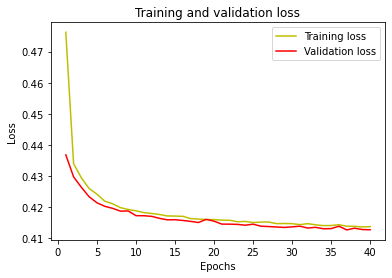

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Vizualizujeme obrázky na vstupe a výstupe enkódera pre kontrolu správnosti fungovania.

In [11]:
#load model
model = load_model('encoder.hdf5')

In [12]:
#enkódovanie a dekódovanie dát
pred = model.predict(X_valid)

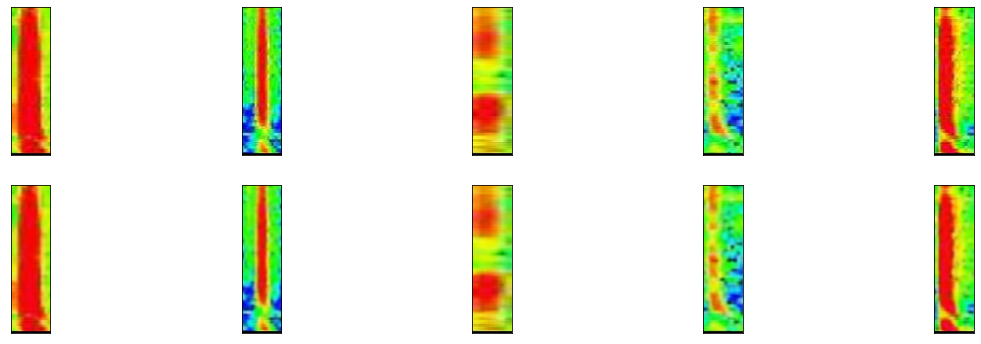

In [13]:
#vizualizovanie enkódovaných a dekódovaných dat
plt.figure(figsize=(20, 6))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_valid[i].reshape(150, 40, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(150, 40, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Vizualizujeme zakódovanú reprezentáciu dát

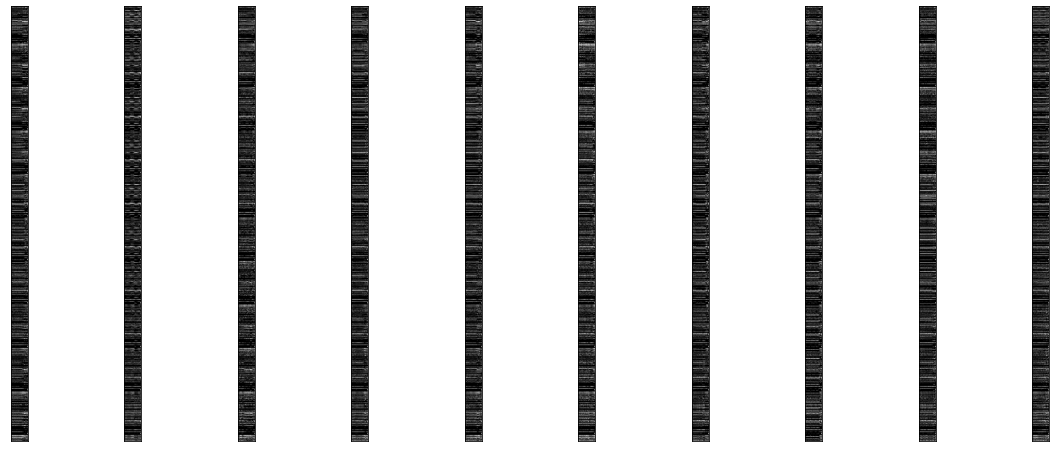

In [14]:
#vizualizovanie zakódovanej reprezentácie
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X_valid)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((25, 10 * 64)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 3. Načítanie a predspracovanie dát
Načítame dáta pre zhlukovanie spolu s príslušnou výstupnou tabuľkou. Dáta zakódujeme pomocou autoenkódera a upravíme ich do tvaru vhodného pre model zhlukovania.

In [15]:
#načítanie dát pre clustering
data = pickle.load(open('data/data_2014_11.pkl', 'rb'))
label = pickle.load(open('data/label_2014_11.pkl', 'rb'))
img_name = pickle.load(open('data/img_name.pkl', 'rb'))

In [44]:
#načítanie výst. tab.
result = pd.read_csv("csv/result_2014_11_cleared.csv")
result

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0
...,...,...,...,...,...,...,...,...,...
13651,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0
13652,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0
13653,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0
13654,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0


In [16]:
#overenie tvaru dát
data.shape

(13647, 150, 40, 3)

In [17]:
label.shape

(13647,)

In [18]:
img_name.shape

(13647,)

In [19]:
#zakódovanie dát
encoded_images = encoder.predict(data)

In [20]:
encoded_images.shape

(13647, 25, 10, 64)

In [21]:
#reshape pre clustering
to_cluster = encoded_images.reshape(-1, 25*10*64)

In [22]:
to_cluster.shape

(13647, 16000)

# 4. Zhlukovanie
Vyskúšali sme zhlukovanie do 2 až 9 zhlukov. Vytvorené zhluky sme vždy vizualizovali formou prvých 10 členov zhluku a informáciu o zhlukoch sme pridali do výstupnej tabuľky.

In [23]:
#clustering do 2 clustrov
kmeans = KMeans(n_clusters=2, random_state = 42)
clustered_training_set = kmeans.fit_predict(to_cluster)

In [24]:
len(clustered_training_set)

13647

In [26]:
#vytvorenie tabuľky imgs s prislúchajúcim clustrom
cluster_K2 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K2

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,1
1,ch2_20141130_185533_304_s41-S2.jpg,0
2,ch2_20141130_071513_250_s80-S6.jpg,0
3,ch2_20141130_161528_669_s90-S2.jpg,1
4,ch2_20141130_001501_274_s119-S3.jpg,0
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,0
13643,ch2_20141130_023005_152_s72-T3.jpg,0
13644,ch2_20141130_173030_842_s80-S6.jpg,0
13645,ch2_20141130_174031_139_s18-S8.jpg,0


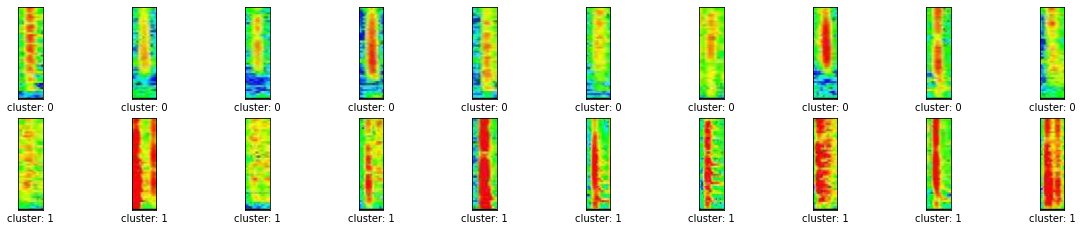

In [29]:
#vizualizácia clustrov
fig = plt.figure(figsize=(20,20))
for r in range(2):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_2clusters.png')

In [45]:
#spojenie clustrov s výst. tab.
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K2.set_index('img')['cluster'])

In [46]:
cluster_df.isnull().sum(axis = 0)

org_img       0
image         0
event         0
date          0
second        0
milisecond    0
tweek         0
f_min<2kHz    0
tweek_sign    0
cluster       9
dtype: int64

In [47]:
#vo výst. tab. bol malý rozdiel v počte dát (9) a po spojení vznikli null hodnoty, ktoré sa vymazali
cluster_df = cluster_df.dropna()

In [48]:
cluster_df.isnull().sum(axis = 0)

org_img       0
image         0
event         0
date          0
second        0
milisecond    0
tweek         0
f_min<2kHz    0
tweek_sign    0
cluster       0
dtype: int64

In [49]:
cluster_df.count()

org_img       13647
image         13647
event         13647
date          13647
second        13647
milisecond    13647
tweek         13647
f_min<2kHz    13647
tweek_sign    13647
cluster       13647
dtype: int64

In [54]:
#úprava výst. tab.
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,0
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,1
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,1
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,0
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,0
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,1
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,0
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,0


In [56]:
#uloženie výst. tab. ako csv súbor
cluster_df.to_csv('cluster_csv/K2_2014_11.csv', index=False)

In [57]:
#clustering 3 clustre
kmeans3 = KMeans(n_clusters=3, random_state = 42)
clustered_training_set = kmeans3.fit_predict(to_cluster)

In [58]:
len(clustered_training_set)

13647

In [59]:
#vytvorenie tabuľky imgs s prislúchajúcim clustrom
cluster_K3 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K3

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,1
1,ch2_20141130_185533_304_s41-S2.jpg,1
2,ch2_20141130_071513_250_s80-S6.jpg,2
3,ch2_20141130_161528_669_s90-S2.jpg,0
4,ch2_20141130_001501_274_s119-S3.jpg,2
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,1
13643,ch2_20141130_023005_152_s72-T3.jpg,1
13644,ch2_20141130_173030_842_s80-S6.jpg,2
13645,ch2_20141130_174031_139_s18-S8.jpg,1


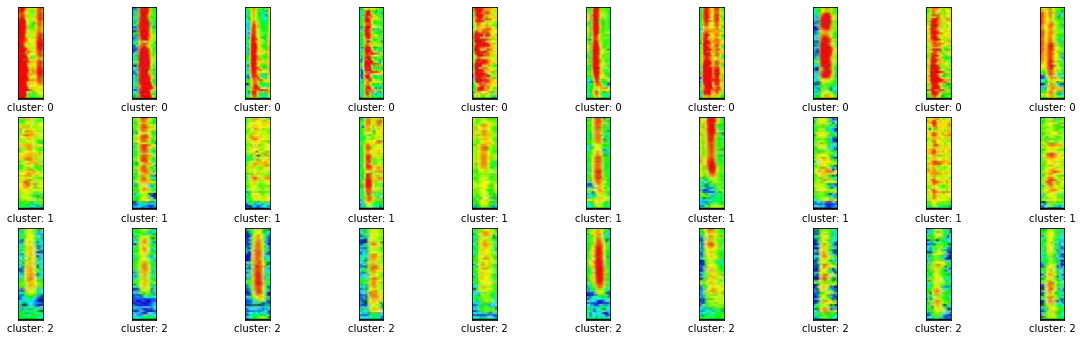

In [60]:
fig = plt.figure(figsize=(20,20))
for r in range(3):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_3clusters.png')
        #plt.ylabel('type: '+str(r))

In [61]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K3.set_index('img')['cluster'])

In [62]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,2
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,0
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,0
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,2
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,1
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,1
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,1
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,1


In [63]:
cluster_df.to_csv('cluster_csv/K3_2014_11.csv', index=False)

In [64]:
#4 cluster
kmeans4 = KMeans(n_clusters=4, random_state = 42)
clustered_training_set = kmeans4.fit_predict(to_cluster)

In [65]:
len(clustered_training_set)

13647

In [66]:
cluster_K4 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K4

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,1
1,ch2_20141130_185533_304_s41-S2.jpg,1
2,ch2_20141130_071513_250_s80-S6.jpg,3
3,ch2_20141130_161528_669_s90-S2.jpg,0
4,ch2_20141130_001501_274_s119-S3.jpg,3
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,1
13643,ch2_20141130_023005_152_s72-T3.jpg,1
13644,ch2_20141130_173030_842_s80-S6.jpg,3
13645,ch2_20141130_174031_139_s18-S8.jpg,1


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(4):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_4clusters.png')
        #plt.ylabel('type: '+str(r))

In [69]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K4.set_index('img')['cluster'])

In [70]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,3
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,0
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,0
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,3
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,1
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,1
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,1
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,1


In [71]:
cluster_df.to_csv('cluster_csv/K4_2014_11.csv', index=False)

In [72]:
kmeans5 = KMeans(n_clusters=5, random_state = 42)
clustered_training_set = kmeans5.fit_predict(to_cluster)

In [73]:
len(clustered_training_set)

13647

In [74]:
cluster_K5 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K5

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,3
1,ch2_20141130_185533_304_s41-S2.jpg,3
2,ch2_20141130_071513_250_s80-S6.jpg,2
3,ch2_20141130_161528_669_s90-S2.jpg,0
4,ch2_20141130_001501_274_s119-S3.jpg,2
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,1
13643,ch2_20141130_023005_152_s72-T3.jpg,3
13644,ch2_20141130_173030_842_s80-S6.jpg,1
13645,ch2_20141130_174031_139_s18-S8.jpg,1


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(5):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_5clusters.png')
        #plt.ylabel('type: '+str(r))

In [77]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K5.set_index('img')['cluster'])

In [78]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,2
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,0
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,0
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,1
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,3
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,3
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,3
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,3


In [79]:
cluster_df.to_csv('cluster_csv/K5_2014_11.csv', index=False)

In [80]:
#6clusters
kmeans6 = KMeans(n_clusters=6, random_state = 42)
clustered_training_set = kmeans6.fit_predict(to_cluster)

In [81]:
len(clustered_training_set)

13647

In [82]:
cluster_K6 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K6

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,2
1,ch2_20141130_185533_304_s41-S2.jpg,2
2,ch2_20141130_071513_250_s80-S6.jpg,0
3,ch2_20141130_161528_669_s90-S2.jpg,1
4,ch2_20141130_001501_274_s119-S3.jpg,0
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,3
13643,ch2_20141130_023005_152_s72-T3.jpg,2
13644,ch2_20141130_173030_842_s80-S6.jpg,3
13645,ch2_20141130_174031_139_s18-S8.jpg,3


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(6):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_6clusters.png')
        #plt.ylabel('type: '+str(r))

In [84]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K6.set_index('img')['cluster'])

In [85]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,0
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,1
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,1
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,3
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,2
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,2
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,2
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,2


In [86]:
cluster_df.to_csv('cluster_csv/K6_2014_11.csv', index=False)

In [87]:
#7clusters
kmeans7 = KMeans(n_clusters=7, random_state = 42)
clustered_training_set = kmeans7.fit_predict(to_cluster)

In [88]:
len(clustered_training_set)

13647

In [89]:
cluster_K7 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K7

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,6
1,ch2_20141130_185533_304_s41-S2.jpg,0
2,ch2_20141130_071513_250_s80-S6.jpg,3
3,ch2_20141130_161528_669_s90-S2.jpg,1
4,ch2_20141130_001501_274_s119-S3.jpg,3
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,0
13643,ch2_20141130_023005_152_s72-T3.jpg,0
13644,ch2_20141130_173030_842_s80-S6.jpg,4
13645,ch2_20141130_174031_139_s18-S8.jpg,0


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(7):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_7clusters.png')
        #plt.ylabel('type: '+str(r))

In [95]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K7.set_index('img')['cluster'])

In [96]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,3
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,1
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,1
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,4
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,6
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,6
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,6
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,0


In [97]:
cluster_df.to_csv('cluster_csv/K7_2014_11.csv', index=False)

In [99]:
#8clusters
kmeans8 = KMeans(n_clusters=8, random_state = 42)
clustered_training_set = kmeans8.fit_predict(to_cluster)

In [100]:
len(clustered_training_set)

13647

In [101]:
cluster_K8 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K8

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,2
1,ch2_20141130_185533_304_s41-S2.jpg,3
2,ch2_20141130_071513_250_s80-S6.jpg,1
3,ch2_20141130_161528_669_s90-S2.jpg,6
4,ch2_20141130_001501_274_s119-S3.jpg,1
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,3
13643,ch2_20141130_023005_152_s72-T3.jpg,3
13644,ch2_20141130_173030_842_s80-S6.jpg,4
13645,ch2_20141130_174031_139_s18-S8.jpg,3


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(8):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_8clusters.png')
        #plt.ylabel('type: '+str(r))

In [103]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K8.set_index('img')['cluster'])

In [104]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,1
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,6
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,6
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,4
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,2
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,2
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,2
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,3


In [105]:
cluster_df.to_csv('cluster_csv/K8_2014_11.csv', index=False)

In [110]:
9#clusters
kmeans9 = KMeans(n_clusters=9, random_state = 42)
clustered_training_set = kmeans9.fit_predict(to_cluster)

In [111]:
len(clustered_training_set)

13647

In [112]:
cluster_K9 = pd.DataFrame(list(zip(img_name, clustered_training_set)), columns =['img', 'cluster'])
cluster_K9

,img,cluster
0,ch2_20141130_010002_554_s12-S3.jpg,2
1,ch2_20141130_185533_304_s41-S2.jpg,2
2,ch2_20141130_071513_250_s80-S6.jpg,5
3,ch2_20141130_161528_669_s90-S2.jpg,4
4,ch2_20141130_001501_274_s119-S3.jpg,5
...,...,...
13642,ch2_20141130_064012_237_s63-S1.jpg,6
13643,ch2_20141130_023005_152_s72-T3.jpg,6
13644,ch2_20141130_173030_842_s80-S6.jpg,0
13645,ch2_20141130_174031_139_s18-S8.jpg,6


In [ ]:
fig = plt.figure(figsize=(20,20))
for r in range(9):
    cluster = r
    for c, val in enumerate(data[clustered_training_set == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val)
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.savefig('img_out/kmeans_9clusters.png')
        #plt.ylabel('type: '+str(r))

In [114]:
cluster_df = result
cluster_df['cluster'] = cluster_df.image.map(cluster_K9.set_index('img')['cluster'])

In [115]:
cluster_df = cluster_df.dropna()
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.drop(['index'], axis = 1)
cluster_df['cluster'] = cluster_df['cluster'].astype(int)
cluster_df

,org_img,image,event,date,second,milisecond,tweek,f_min<2kHz,tweek_sign,cluster
0,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S1.jpg,1,20141130_000500,122,867,0,0,0,5
1,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-T1.jpg,1,20141130_000500,122,990,1,1,4,4
2,ch2_20141130_000500_988_s122,ch2_20141130_000500_988_s122-S2.jpg,2,20141130_000500,122,992,0,1,0,4
3,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S1.jpg,1,20141130_000500,125,5,0,1,0,6
4,ch2_20141130_000500_988_s125,ch2_20141130_000500_988_s125-S2.jpg,2,20141130_000500,125,158,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13642,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S13.jpg,13,20141130_235542,9,824,0,1,0,2
13643,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S14.jpg,14,20141130_235542,9,884,0,0,0,2
13644,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S15.jpg,15,20141130_235542,9,916,0,0,0,2
13645,ch2_20141130_235542_205_s9,ch2_20141130_235542_205_s9-S16.jpg,16,20141130_235542,9,939,0,0,0,6


In [116]:
cluster_df.to_csv('cluster_csv/K9_2014_11.csv', index=False)